# Introduction
This notebook implements Logistic Regression with Gradient Descent. 

- Algorithm: Logistic Regression
- DataSets:   "logistic_regression" and "breast_cancer"
- Video: To Be Added.


# Logistic Regression
Run the following code and take a good look at the data

<IPython.core.display.Javascript object>


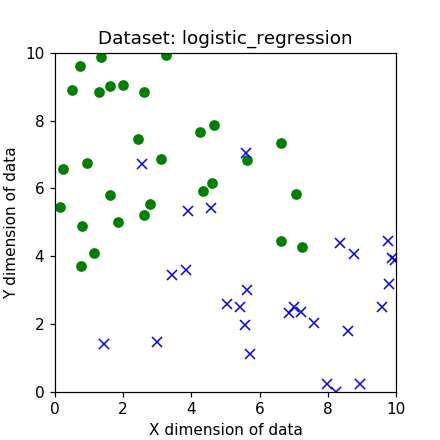

In [1]:
import ipython_import_class
import DataSet as ds
import numpy as np

data = ds.DataSet("logistic_regression", n=100, var=3, means=np.array([[2,8], [8,2]]))
data.plot()

This data can't be seperated by a line. A few blue and green points might seem out of place. If we used the Pocket algorithm to classify this dataset, each point would be assigned exactly one cluster. 

Are more nuanced approach would be to assign each point a probability for each class. The points on the border might get 50/50% probability of each class, where the points further away will get higher probability. To model probabilities we will use the sigmoid function 

$$\sigma(x)=\frac{1}{1+e^{-x}}$$

The following code plots $\sigma(x)$ for $x\in[-10, 10]$

<IPython.core.display.Javascript object>


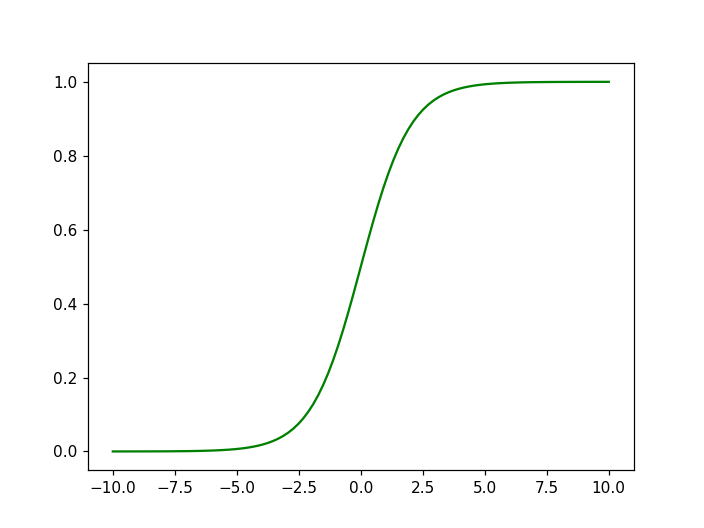

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

xs = np.linspace(-10, 10, 100)
ys = 1/(1+np.exp(-xs))
plt.plot(xs, ys, '-g')
plt.show()

Notice that $\sigma(x)$ takes values only in the interval $[0, 1]$. This allows us to interpret $\sigma(w^Tx)$ as the probability of $x$ being class $+1$ and $1-\sigma(w^Tx)$ as the probability of $x$ being class $-1$. Our hypothesis set will be

$$H = \{ h(x)=\sigma(w^Tx)\mid w\in\mathbb{R}^{d+1}\}$$

Given data $D=\{(x_1,y_1),...,(x_N, y_N)\}$ we want to minimize the following error function 

$$E_{in}(h)=- \sum_{i=1}^N y_i \log h(x_i) + (1-y_i)\log (1-h(x_i)) $$

For now we will use this as our error function without further justification. We will later show that minimizing $E_{in}$ is the same as finding the weights $w$ that maximizes the likelihood of our data; that is, find weights $w$ that maximize $P(D\mid w)$. 

Our goal is still to find weights $w$ such that we minimize the in-sample error $E_{in}(w)$. Unfortunately, for Logistic Regression we do not have a formula that computes the optimal weights. The gradient can be found [1] to be 

$$\nabla_w E_{in}(w)=-X^T(y-\sigma(Xw))$$

In the code below we use this as a fact. 

# Code: Logistic Regression
The following code implements the class `Logistic Regression`. For simplicity all visualization code have been moved to `hide_visualization_code`. 

In [3]:
%matplotlib notebook
import ipython_import_class
import DataSet as ds
import hide_visualization_code
import numpy as np
import matplotlib.pyplot as plt
import time

class LogisticRegression:
    
    def __init__(self, visualize=False, learning_rate=0.00001, sleep=0.0):
        self.visualize = visualize
        self.learning_rate = learning_rate
        self.xlim = None
        self.ylim = None
        
        if self.visualize: 
            self.fig, (self.ax_data, self.ax_error, self.ax_error_01) = plt.subplots(1, 3, figsize=(10, 5))
            self.errors = []   
            self.errors_01 = []
            self.sleep = sleep
            self.fig.tight_layout()
    
    def fit(self, X, y, rounds=1000):
        N, d = X.shape
        
        # labels should be {0, 1} and not {-1, +1}
        if set(y) == {-1, +1}: y = (y+1)/2
        elif set(y) != {0, +1}: assert False, ("Labels should be {0, 1} for Logistic Regression but was: ", set(y))
        
        # Initialize weights randomly
        self.w = np.random.rand(d)
        
        # Take 'rounds' steps in the direction of the negative gradient
        for i in range(rounds):
            # Compute Gradient
            gradient = self.gradient(X, y)
            
            # Update weights
            self.w = self.w - self.learning_rate * gradient
            
            # Visualize if enabled. 
            if self.visualize: self.do_visualize(X, y)
      
    
    def sigmoid(self, x):
        return 1/(1+np.exp(x))
    
    def gradient(self, X, y): 
        return X.T @ (y - self.sigmoid(X @ self.w))
    
    def predict(self, X):
        return self.sigmoid(X @ self.w)
    
    def error(self, X, y):
        N, d = X.shape
        
        # Compute the inner product vector
        Xw = X @ self.w
        
        # Compute each part of the sum
        Xw_1 = np.log(self.sigmoid(Xw[y==1]))
        Xw_0 = np.log(self.sigmoid(1-Xw[y==0]))
        
        return - 1/N*(np.sum(Xw_1) + np.sum(Xw_0))
    
    def classification_error(self, X, y):
        ''' Compute probability of each point and assign most likely class, then
        compute zero-one loss. '''
        # labels should be {0, 1} and not {-1, +1}
        if set(y) == {-1, +1}: y = (y+1)/2
        elif set(y) != {0, +1}: assert False, ("Labels should be {0, 1} for Logistic Regression but was: ", set(y))
        
        pred = self.predict(X)
        hard_assign = (pred >= 0.5)
        accuracy = np.mean(hard_assign == y) 
        return 1 - accuracy

    def do_visualize(self, X, y):
        hide_visualization_code.visualize_logreg(self, X, y)

Let's try to run `LogisticRegression` on some data. 

<IPython.core.display.Javascript object>


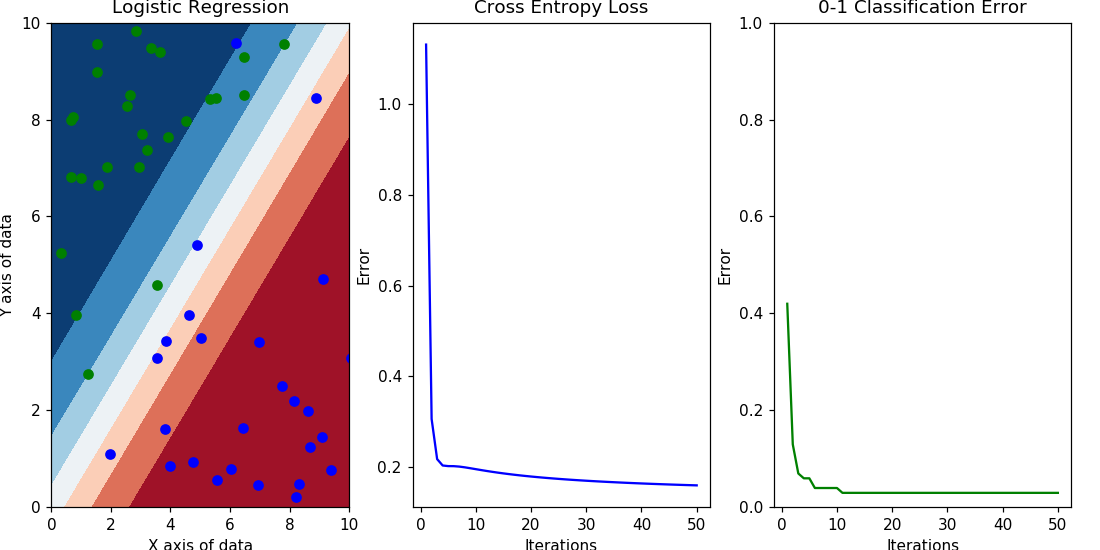

Classification Error:  0.03


In [4]:
data = ds.DataSet("logistic_regression", n=100, var=3, means=np.array([[2,8], [8,2]]))

logreg = LogisticRegression(visualize=True, learning_rate=0.001)
logreg.fit(data.X, data.y, rounds=50)

print("Classification Error: ", logreg.classification_error(data.X, data.y))

# (not done yet) Math: A noisy target function
Before we considered a target function $f:X\rightarrow y$ that for each $x$ assigned either yes $(+1)$ or no $(-1)$. Here we will instead consider a noisy target function $f(x)=P(y=+1\mid x)$. This changes the target function from saying $+1$ or $-1$ to saying $+1$ with some probability $p$ and $-1$ with probability $1-p$.

Our goal is now to find a hypothesis $h(x)=\sigma(w^Tx)$ such that

$$ P(y\mid x) \approx P_h(y\mid x)=
\begin{cases}h(x) 
& y=+1\\
1-h(x) & y =-1 \end{cases}$$

In this sense, you should think of 
 1. $h(x)$ as the probability $x$ is in class $+1$, that is $h(x)\approx P(y=+1\mid x)$. 
 2. $1-h(x)$ as the probability of $x$ being in class $-1$, that is $h(x)\approx P(y=-1 \mid x)$
 
By using a little trick it is possible to condense the form of $P_h(y\mid x)$. Remember that $h(x)=\sigma(w^T x)$ ...


<div style="border: 1px solid black; background-color: #eaeaea; padding: 16px; margin: 16px; text-align: center; font-weight: bold;">To be continued. </div>

# Experiment: Breast Cancer dataset
Before running Logistic Regression on the Breast Cancer dataset, we will make a slight change to the Logistic Regression code. Instead of using the last weights obtained, we will keep the best weights over $T$ iterations. This is the same trick we used to make the `Pocket` algorithm!

In [5]:
import ipython_import_class
import hide_visualization_code

class LogisticRegressionSave(LogisticRegression):
    
    def fit(self, X, y, rounds=20000):
        n, d = X.shape
        
        # labels should be {0, 1} and not {-1, +1}
        if set(y) == {-1, +1}: y = (y+1)/2
        elif set(y) != {0, +1}: assert False, ("Labels should be {0, 1} for Logistic Regression but was: ", set(y))
        
        # Initialize weights randomly
        self.w = np.random.rand(d)
        
        # Initialize best error to the worst   
        best_error = 1.0                       
        self.best_w = np.zeros(d)           
        
        # Take 'rounds' steps in the direction of the negative gradient
        for i in range(rounds):
            # Compute Gradient
            gradient = self.gradient(X, y)
            
            # Update weights
            self.w = self.w - self.learning_rate * gradient
            
            # If current error is better than previous update best error and      
            # best weights.                                                       
            current_error = self.error(X, y)                                   
            if current_error < best_error:                                        
                best_error = current_error                                        

                self.best_w = np.copy(self.w) # copy and save the best weights.   
                # If we get zero in-sample error we are done.                     
                if best_error == 0:                                               
                    return                                                        
            
            # Visualize if enabled. 
            if self.visualize: self.visualize_logreg(X, y)
        
        # Set weights to be the best found. 
        self.w = self.best_w
        
        
    def visualize_logreg(self, X, y):
        hide_visualization_code.visualize_logreg_save(self, X, y)

Let's try to run Logistic Regression on the 2d Breast Cancer dataset. 

<IPython.core.display.Javascript object>


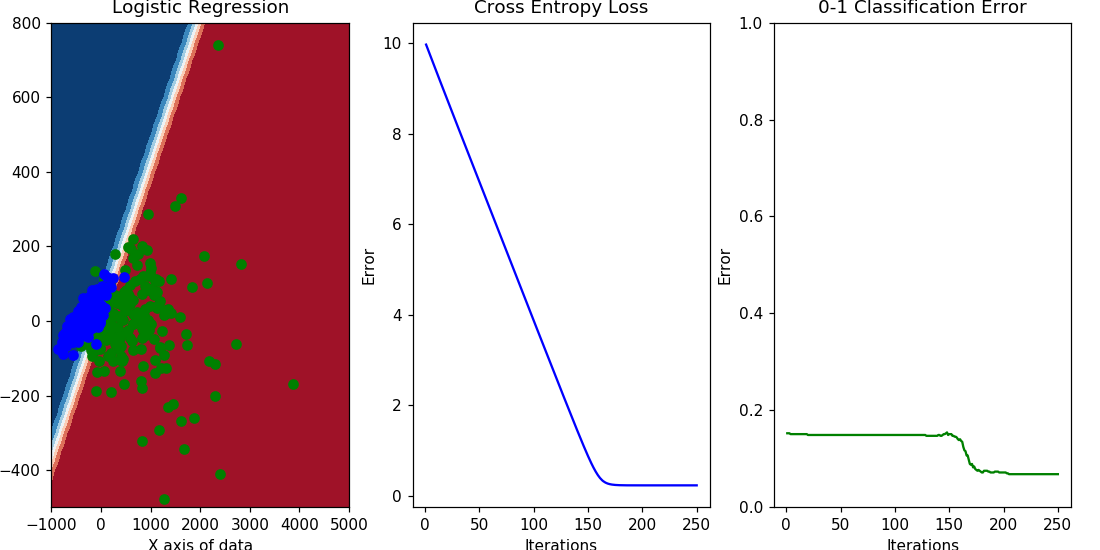

/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in exp


Classification Error:  0.0720562390158


In [6]:
import ipython_import_class
import DataSet as ds

data = ds.DataSet("breast_cancer_2d")

p = LogisticRegressionSave(visualize=True, learning_rate=0.000001)

# Adjust plot axis
p.xlim = [-1000,5000]
p.ylim = [-500, 800] 

p.fit(data.X, data.y, rounds=250)

print( "Classification Error: ", p.classification_error(data.X, data.y))

This should get around 7.5% error! Let's try to run Logistic Regression on the original 30 dimensional breast cancer dataset. 

In [7]:
data = ds.DataSet("breast_cancer")

p = LogisticRegressionSave(visualize=False, learning_rate=0.000005)
p.fit(data.X, data.y, rounds=20000)

print( "Final Error: ", p.classification_error(data.X, data.y))

/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in exp


Final Error:  0.0439367311072


This should give around 4% error. The following sections compare all the different algorithms. 

# Experiment: Pocket vs Linear Regression vs Logistic Regression
Let's try to compare all the algorithms on the breast cancer data set. 

In [8]:
# Make this into a class that takes a list of estimators and additional fit parameters. 
import ipython_import_class
import DataSet as ds
import Perceptron 
import LinearRegression 

data   = ds.DataSet("breast_cancer")
data2d = ds.DataSet("breast_cancer_2d")

results = np.zeros((3,2))

iterations = 300

print("ALGORITHM\t2d, 30d")

pocket   = Perceptron.Pocket()
pocket2d = Perceptron.Pocket()
pocket.fit(data.X, data.y, T=iterations)
pocket2d.fit(data2d.X, data2d.y, T=iterations)
results[0] = [pocket2d.classification_error(data2d.X, data2d.y), pocket.classification_error(data.X, data.y)]
print("Pocket\t", results[0])

linreg   = LinearRegression.LinearRegressionClassification()
linreg2d = LinearRegression.LinearRegressionClassification()
linreg.fit(data.X, data.y)
linreg2d.fit(data2d.X, data2d.y)
results[1] = [linreg2d.classification_error(data2d.X, data2d.y), linreg.classification_error(data.X, data.y)]
print("LinReg\t", results[1])

logreg   = LogisticRegressionSave(learning_rate=0.000005)
logreg2d = LogisticRegressionSave(learning_rate=0.000001)
logreg.fit(data.X, data.y, rounds=iterations)
logreg2d.fit(data2d.X, data2d.y, rounds=iterations)
results[2] = [logreg2d.classification_error(data2d.X, data2d.y), logreg.classification_error(data.X, data.y)]
print("LogReg\t", results[2])

ALGORITHM	2d, 30d
Pocket	 [ 0.07205624  0.0685413 ]
LinReg	 [ 0.12653779  0.03514938]
LogReg	 [ 0.08084359  0.05975395]


/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in exp


Try to run the experiment for different values of $T$. The accuracies of the algorithms on the breast cancer is roughly the same. 

# Errors, Suggestions and Hall Of Fame
If you find any mistakes or have suggestions for improvements reach me at alexmath@cs.au.dk. Any help is very much appreciated, I'll even add your name below for super-awesome everlasting fame!

- Rasmus Skovdal: Last section 30d and 2d was swapped. 

# Discussion
<iframe src="..discussionboard/perceptron.html" style="width: 800px; height: 800px; "/></iframe>